# Classification problem

## The problem that has been chosen is about the water quality, given a set of data <br>we have to be able to classify if a given type of water is drinkable or not, so it is a binary classification problem, with labeled data (supervised).

### the original data can be downloaded for free from kaggle in this link <br> https://www.kaggle.com/datasets/nayanack/water-probability?resource=download

### Importing the libraries and the data

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import entropy
from scipy import stats
from math import log
from math import exp


In [70]:
data = pd.read_csv("./data/water_potability.csv", sep = ',')
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


### Exploratory analysis

cheching null values: 

In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [72]:
data.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [73]:
rows_without_null = data.notnull().all(axis=1).sum()


In [74]:
print(f"original rows: {data.shape[0]} rows after eliminating the null values {data.shape[0] - rows_without_null}.\
 \nthat mean losing the {round((rows_without_null/data.shape[0])*100,2)} % of the data")


original rows: 3276 rows after eliminating the null values 1265. 
that mean losing the 61.39 % of the data


We cannot eliminate all the rows with null values, filling the missing data seems like a reasonable option. <br> Before using the mean for each column the data with the mean we have to check the outlier and the distribution of each series, because the mean can be a decieving mesure in those cases.

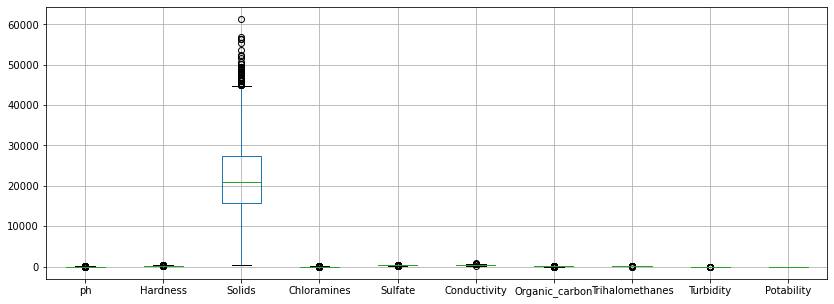

In [75]:
data.boxplot(figsize = (14,5))
plt.show()

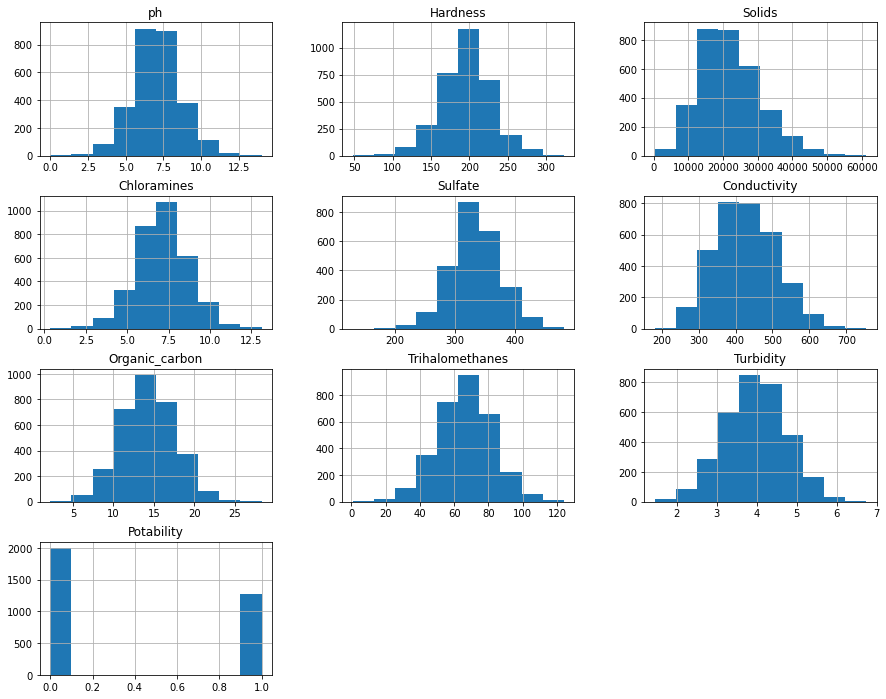

In [76]:
data.hist(figsize = (15,12))
plt.show()

In [77]:
data.columns

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

the [solids] column contains outliers and is less symetrical than the rest of the variables that seem normaly distributed. <br>
So it make sense to fill the data with the median that is a more robust extimator. <br>
For all the other variables we can use the mean.

In [78]:
data['Solids'] = data['Solids'].fillna(data['Solids'].median())
data = data.fillna(data.mean())

Checking if the classes are balanced or not

([<matplotlib.axis.XTick at 0x20d388adac0>,
 [Text(0, 0, ''), Text(0, 0, '')])

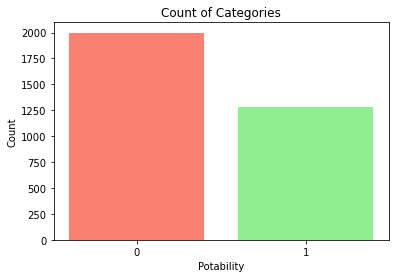

In [79]:
counts = data['Potability'].value_counts()

# Create count plot using matplotlib
colors= ['salmon','lightgreen']

plt.bar(counts.index, counts.values, color=colors )
plt.xlabel('Potability')
plt.ylabel('Count')
plt.title('Count of Categories')
plt.xticks([0, 1])

In [80]:
count_1 = (data['Potability']==1).sum()
percentage_1 = round((count_1 / len(data['Potability'])*100),2)
print(f"the data are mildy imbalaced cause we have a {percentage_1}% of positive values.\nWe need to take \
this into account in the moment of chosing the evaluation metrics")

the data are mildy imbalaced cause we have a 39.01% of positive values.
We need to take this into account in the moment of chosing the evaluation metrics


### Correlations analysis

Since the target variable is binary we cannot use the Pearson's correlation but better use point biserial correlation coefficient, or the spearman ranking correalation instead.


In [81]:
# function to see it clearly what are the most correlated variables with our target variable
def order_by_correlation_size(df: pd.DataFrame(),target_variable :str ='Potability'):
    # order a df from based on the correlation with the target variable in a decreasing order.

    correlation_matrix = df.corr(method='spearman')
    max_correlation_with_target = correlation_matrix[target_variable].drop([target_variable]).abs().sort_values(ascending=False)
    ordered_columns = max_correlation_with_target.index.tolist()
    df = df[[target_variable] + ordered_columns]
    return df

In [82]:
# the last column
data = order_by_correlation_size(data)
data.corr(method='spearman')

,Potability,Organic_carbon,Solids,Chloramines,Sulfate,Hardness,Conductivity,Trihalomethanes,ph,Turbidity
Potability,1.000000,-0.026774,0.026234,0.024980,-0.012522,-0.010606,-0.010386,0.005561,-0.003700,0.001088
Organic_carbon,-0.026774,1.000000,0.017881,-0.011910,0.012287,0.003340,0.021311,-0.007326,0.038681,-0.024730
Solids,0.026234,0.017881,1.000000,-0.055037,-0.130586,-0.052584,0.021089,-0.018985,-0.063675,0.028470
Chloramines,0.024980,-0.011910,-0.055037,1.000000,0.026533,-0.024556,-0.016928,0.017682,-0.036997,-0.007909
Sulfate,-0.012522,0.012287,-0.130586,0.026533,1.000000,-0.073857,-0.016552,-0.020319,0.022249,-0.016757
Hardness,-0.010606,0.003340,-0.052584,-0.024556,-0.073857,1.000000,-0.032884,-0.010295,0.106929,-0.012855
Conductivity,-0.010386,0.021311,0.021089,-0.016928,-0.016552,-0.032884,1.000000,-0.004260,0.013797,0.010342
Trihalomethanes,0.005561,-0.007326,-0.018985,0.017682,-0.020319,-0.010295,-0.004260,1.000000,0.006284,-0.027047
ph,-0.003700,0.038681,-0.063675,-0.036997,0.022249,0.106929,0.013797,0.006284,1.000000,-0.046972
Turbidity,0.001088,-0.024730,0.028470,-0.007909,-0.016757,-0.012855,0.010342,-0.027047,-0.046972,1.000000


In [83]:
for col in data.columns:
    print (f"variable: {col}, {stats.pointbiserialr(x= data[col],y= data['Potability'])}")

variable: Potability, PointbiserialrResult(correlation=0.9999999999999831, pvalue=0.0)
variable: Organic_carbon, PointbiserialrResult(correlation=-0.030001366610944553, pvalue=0.08599746163831462)
variable: Solids, PointbiserialrResult(correlation=0.033743313393649804, pvalue=0.053463638184233594)
variable: Chloramines, PointbiserialrResult(correlation=0.023778971994669506, pvalue=0.1736102246498992)
variable: Sulfate, PointbiserialrResult(correlation=-0.020619084357933606, pvalue=0.2380653660511171)
variable: Hardness, PointbiserialrResult(correlation=-0.013836558085111373, pvalue=0.4285415874064298)
variable: Conductivity, PointbiserialrResult(correlation=-0.00812831972154544, pvalue=0.6418845485941129)
variable: Trihalomethanes, PointbiserialrResult(correlation=0.006960211364796229, pvalue=0.6904607285457369)
variable: ph, PointbiserialrResult(correlation=-0.0032868434924190203, pvalue=0.8508330312674878)
variable: Turbidity, PointbiserialrResult(correlation=0.0015806819539223205, p

The two kinds of correlations give similar results.<br>I am using the spearman correlation for visualization purpuses because it's faster to use cause it is already implemented in the pandas corr method. <br>
Furthermore we can see that the values of the correlations against the target variables are very low and just the variables [Organic_carbon], [Solids] are significant if we chose an alpha = 0,1

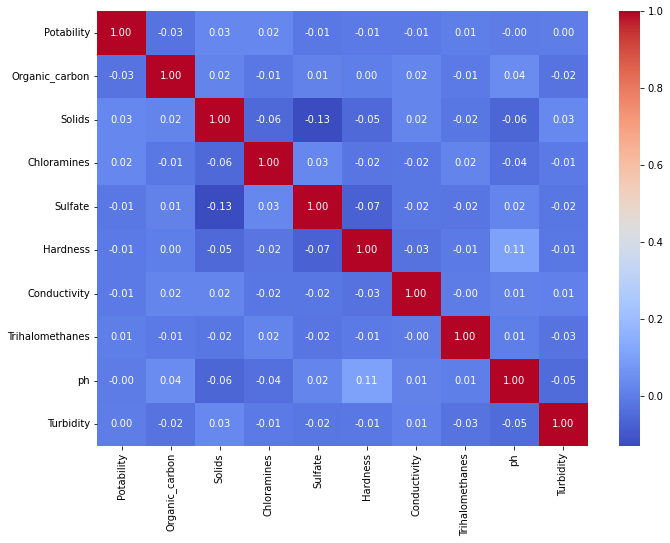

In [84]:
sns.heatmap(data.corr(method='spearman'), annot= True ,cmap='coolwarm', fmt=".2f")
figure = plt.gcf()
figure.set_size_inches(11,8)
plt.show()

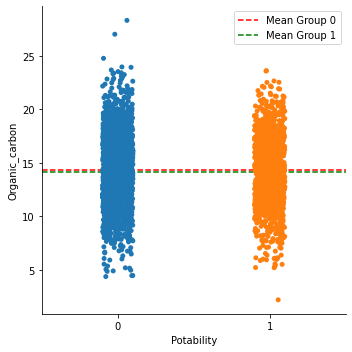

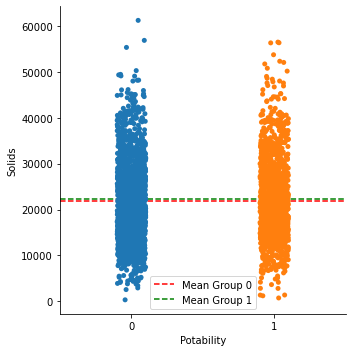

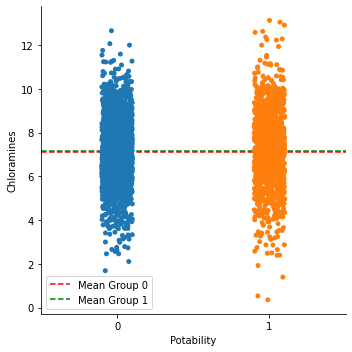

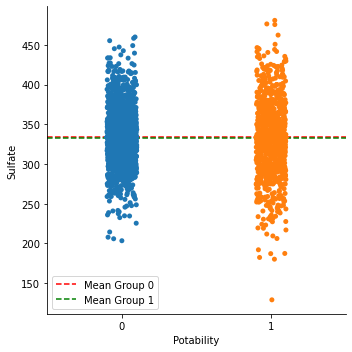

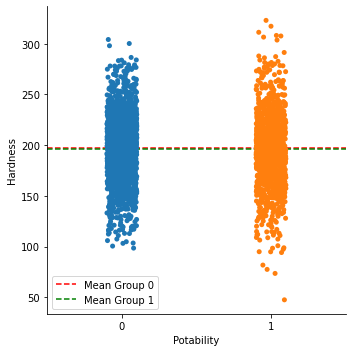

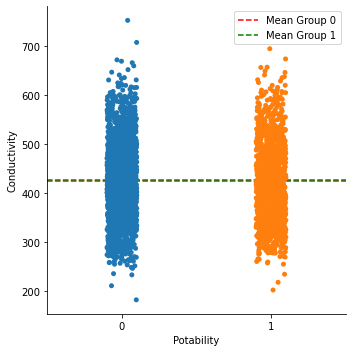

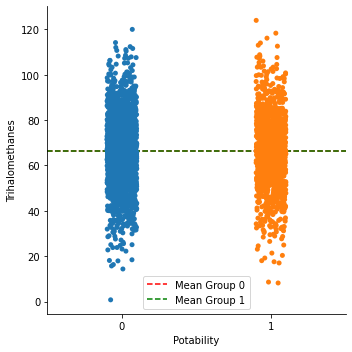

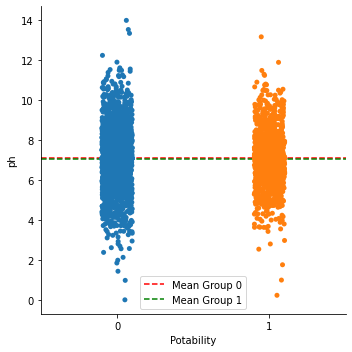

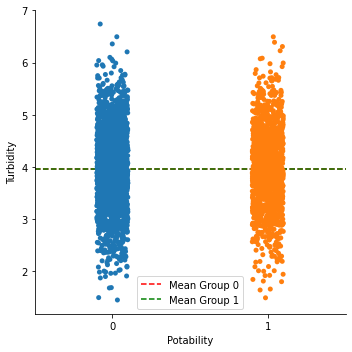

In [85]:
line_colors = ['r', 'g']  # Example colors, you can adjust as needed

# Loop through each column (excluding "Potability")
for col in data.columns:
    if col != "Potability":
        # Create catplot with stripplot instead of swarmplot
        catplot = sns.catplot(data=data, x="Potability", y=col, order=[0, 1], kind="strip")
        
        # Calculate mean of each group
        means = data.groupby('Potability')[col].mean()
        
        # Plot horizontal lines representing the mean of each group
        for i, (mean, color) in enumerate(zip(means, line_colors)):
            plt.axhline(mean, color=color, linestyle='--', label=f'Mean Group {i}')
        
        # Show plot
        plt.legend()
        plt.show()

The variable distributions conditioned to the seems not to vary much if conditioned to the target value variable.<br>
It is unuseful to make some Anova because we will already know that there is not any statistically significant difference in between
the conditionated distribution, So we can try some feature transformations in order to find stronger relationships.

### Feature transformations

the 1st test we can do is to remove the outliers value to the [Solids] variable and check the new value of correlation: 


In [86]:
def replace_outliers(df: pd.DataFrame(), column_name:str):
    # this function use interquartilic distance to substitute the oultiers with the threshol value used to detect the outliers
    df1= df[[column_name]].copy()
    # Calculate the first quartile (Q1) and third quartile (Q3)
    
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1
    outlier_threshold = 1.5 * IQR
    df1[column_name] = np.where(df[column_name] > Q3 + outlier_threshold , Q3 + outlier_threshold, df[column_name]).copy()
    df1[column_name] = np.where(df[column_name] < Q1 - outlier_threshold, Q1 - outlier_threshold, df1[column_name])
    return df1[column_name]

In [87]:
Solid_original = data['Solids']
Solid_no_outlier= replace_outliers(data,'Solids')

In [88]:
(Solid_original != Solid_no_outlier).sum()

47

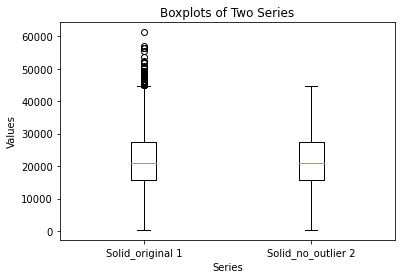

In [89]:
# Create a figure and axis object
fig, ax = plt.subplots()

# Create boxplots for both Series on the same axis
ax.boxplot([Solid_original, Solid_no_outlier])

# Add title and labels
ax.set_title('Boxplots of Two Series')
ax.set_xlabel('Series')
ax.set_ylabel('Values')

# Set x-axis tick labels
ax.set_xticklabels(['Solid_original 1', 'Solid_no_outlier 2'])

# Show plot
plt.show()

In [90]:
print (f"variable:Solid_original, {stats.pointbiserialr(Solid_original, y=data['Potability'] )}")
print (f"variable:Solid_no_outlier, {stats.pointbiserialr(Solid_no_outlier, y=data['Potability'] )}")

variable:Solid_original, PointbiserialrResult(correlation=0.033743313393649804, pvalue=0.053463638184233594)
variable:Solid_no_outlier, PointbiserialrResult(correlation=0.031846909749484384, pvalue=0.06836891017075605)


The ouliers treatment doesn't improve the performance we will have to try some other transformations. <br>
Let us create a matrix with all the original correlations values that will be compared with the new coefficients obtained from the transformed variables.

In [91]:
def compute_corr_point_benchmark(df: pd.DataFrame(), column_name:str, target_var:str='Potability'):
    dict_var = {}
    if column != 'Potability':  # Exclude 'Potability' column
        correlation, p_value = stats.pointbiserialr(x=data[column], y=data['Potability'] )
        dict_var[column] = (correlation)
    df_results = pd.DataFrame.from_dict(pointbiserial_dict, orient='index', columns=['Correlation_original'])
    return df_results[column]

In [92]:

# Calculate point-biserial correlation for each column
dict_var = {}
for column in data.columns:
    if column != 'Potability':
        correlation, p_value = stats.pointbiserialr(x=data[column], y=data['Potability'] )
        dict_var[column] = (correlation)
df_benchmark = pd.DataFrame.from_dict(dict_var, orient='index', columns=['Correlation_original'])

df_benchmark


,Correlation_original
Organic_carbon,-0.030001
Solids,0.033743
Chloramines,0.023779
Sulfate,-0.020619
Hardness,-0.013837
Conductivity,-0.008128
Trihalomethanes,0.006960
ph,-0.003287
Turbidity,0.001581


For each independent variable we try several transformation, like quadratic, cubic or logaritmic

In [93]:
# identifying the columns that need to be scaled before computing the exponential.
col_high_value = ["Sulfate","Solids","Hardness","Conductivity","Trihalomethanes"]

df_trans = data.copy()
col_selected = [x for x in data.columns if x !='Potability']
# quadratic and cubic
trans_type = "_power_"
# deciding the degree of power in this loop
for power in range(2,10):
    for var in col_selected:
        df_trans[var+trans_type+str(power)] = df_trans[var].apply(lambda x: x ** power)
# squared root
trans_type = "_sq_root"       
for var in col_selected:
    df_trans[var+trans_type] = df_trans[var].apply(lambda x: x ** 0,5)
    
# logatirmic
trans_type = "_log"        
for var in col_selected:
    df_trans[var+trans_type] = df_trans[var].apply(lambda x: log(x) if x > 0 else None)
    df_trans[var+trans_type].fillna(df_trans[var+trans_type].mean())

#subtracting the mean for each variable
trans_type = "centered"
for var in col_selected:
    df_trans[var+trans_type] = df_trans[var].apply(lambda x: x - data[var].mean() )


#exponential 
trans_type = "_exp"
for var in col_selected:
    # transforming for a constant to avoid values too big to compute
    if var in col_high_value:
        df_trans[var] = df_trans[var].apply(lambda x: x / 100)

    df_trans[var+trans_type] = df_trans[var].apply(lambda x: exp(x) if abs(x) < 500 else None)
    df_trans[var+trans_type].fillna(df_trans[var+trans_type].mean())


C:\Users\acanino\AppData\Local\Temp\ipykernel_22784\3345887481.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trans[var+trans_type] = df_trans[var].apply(lambda x: x - data[var].mean() )
C:\Users\acanino\AppData\Local\Temp\ipykernel_22784\3345887481.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_trans[var+trans_type] = df_trans[var].apply(lambda x: exp(x) if abs(x) < 500 else None)
C:\Users\acanino\AppData\Local\Temp\ipykernel_22784\3345887481.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is 

Another kind of transformation that could be tried is to create categorical variables. <br>
This is not included for time constraints.

In [94]:
num_null_values = df_trans.isna().any().sum()

print("Number of null values:", num_null_values)

Number of null values: 2


In [95]:
df_trans= df_trans.fillna(df_trans.mean())

In [96]:
# Calculate point-biserial correlation for each column, ph_log has been excluded for computational problems
dict_trans = {}
for column in df_trans.columns:
    if column not in data.columns:
        # calculating the correlation with the y:
        correlation, p_value = stats.pointbiserialr(x=df_trans[column], y=data['Potability'] )
        dict_trans[column] = correlation
df_compare = pd.DataFrame.from_dict(dict_trans, orient='index', columns=['Correlation_transformed'])




C:\Users\acanino\Anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [97]:
# recreating the original column in the transofmed table.
df_compare['original_column'] = df_compare.apply(lambda row: [x for x in data.columns if row.name.startswith(x)], axis=1)
df_compare['original_column'] = df_compare.apply(lambda row: row['original_column'][0], axis=1)
df_compare = df_compare.fillna(0)


In [98]:
# creating a df to compare the correlations
df_comparison = pd.merge(df_benchmark, df_compare, left_index = True, right_on ='original_column', how='left')
df_comparison = df_comparison.drop(columns=['original_column'])
# calculating differences in between the correlations
df_comparison['Performance_abs'] = abs( abs(df_comparison['Correlation_transformed'] - df_comparison['Correlation_original']) )
# calculating the odds against the correlation of the original variable
df_comparison['Performance_odd'] = abs(df_comparison['Correlation_transformed'])/ abs(df_comparison['Correlation_original']) 
df_comparison.head()


,Correlation_original,Correlation_transformed,Performance_abs,Performance_odd
Organic_carbon_power_2,-0.030001,-0.031849,0.001848,1.061590
Organic_carbon_power_3,-0.030001,-0.033594,0.003593,1.119762
Organic_carbon_power_4,-0.030001,-0.035132,0.005130,1.171008
Organic_carbon_power_5,-0.030001,-0.036382,0.006381,1.212694
Organic_carbon_power_6,-0.030001,-0.037246,0.007245,1.241488


In [99]:
df_comparison_sel = df_comparison[df_comparison['Performance_odd']>1.00001]
df_comparison_sel = df_comparison_sel.sort_values(by='Performance_odd', ascending=False)
df_comparison_sel

,Correlation_original,Correlation_transformed,Performance_abs,Performance_odd
ph_power_7,-0.003287,-0.043075,0.039788,13.105298
ph_power_6,-0.003287,-0.043011,0.039724,13.085734
ph_power_8,-0.003287,-0.041436,0.038149,12.606534
ph_power_5,-0.003287,-0.040632,0.037345,12.361981
ph_power_9,-0.003287,-0.038782,0.035495,11.799077
...,...,...,...,...
Organic_carbon_power_3,-0.030001,-0.033594,0.003593,1.119762
Solids_power_6,0.033743,0.037057,0.003314,1.098210
Organic_carbon_power_2,-0.030001,-0.031849,0.001848,1.061590
Turbidity_power_3,0.001581,0.001655,0.000074,1.046989


In [100]:
# checking if we miss some degrees of polynomial variables
df_comparison_sel_sorted= df_comparison_sel.sort_index(axis=0)
df_comparison_sel_sorted.index

Index(['Chloramines_exp', 'Chloramines_power_2', 'Chloramines_power_3',
       'Chloramines_power_4', 'Chloramines_power_5', 'Chloramines_power_6',
       'Chloramines_power_7', 'Chloramines_power_8', 'Chloramines_power_9',
       'Conductivity_log', 'Hardness_log', 'Hardness_power_4',
       'Hardness_power_5', 'Hardness_power_6', 'Hardness_power_7',
       'Hardness_power_8', 'Hardness_power_9', 'Organic_carbon_power_2',
       'Organic_carbon_power_3', 'Organic_carbon_power_4',
       'Organic_carbon_power_5', 'Organic_carbon_power_6',
       'Organic_carbon_power_7', 'Organic_carbon_power_8',
       'Organic_carbon_power_9', 'Solids_power_2', 'Solids_power_3',
       'Solids_power_4', 'Solids_power_5', 'Solids_power_6', 'Sulfate_exp',
       'Sulfate_log', 'Sulfate_power_5', 'Sulfate_power_6', 'Sulfate_power_7',
       'Sulfate_power_8', 'Sulfate_power_9', 'Trihalomethanes_exp',
       'Trihalomethanes_power_2', 'Trihalomethanes_power_3',
       'Trihalomethanes_power_4', 'Trihalom

checking that every variable with power transformation has all the degree until the top one.


In [101]:
#the var 'Hardness'has a prro performance on the 1st degrees of polinomials, let us evaluate if to put that variable in the model
col_to_add_= df_comparison_sel_sorted.index
df_comparison_sel[df_comparison_sel.index.str.contains('Hardness')]

,Correlation_original,Correlation_transformed,Performance_abs,Performance_odd
Hardness_power_9,-0.013837,0.045369,0.059206,3.278954
Hardness_power_8,-0.013837,0.041753,0.055590,3.017595
Hardness_power_7,-0.013837,0.037157,0.050993,2.685417
Hardness_power_6,-0.013837,0.031490,0.045327,2.275865
Hardness_log,-0.013837,-0.026246,0.012409,1.896844
Hardness_power_5,-0.013837,0.024694,0.038531,1.784716
Hardness_power_4,-0.013837,0.016748,0.030585,1.210413


it looks like a relativley good performance improvement, so we should include as well the missing degrees of power

In [102]:
col_to_add = list(col_to_add_) +['Hardness_power_2','Hardness_power_3']
col_to_add = df_comparison_sel.index


In [103]:
# merging the df with the original one to get the one we will use for modelling.
df_trans = df_trans[col_to_add].copy()
df_model = pd.merge(data, df_trans, left_index = True, right_index =True, how='left')

In [104]:
corr= df_model.corr()
corr.sort_index(axis=0)

,Potability,Organic_carbon,Solids,Chloramines,Sulfate,Hardness,Conductivity,Trihalomethanes,ph,Turbidity,...,Solids_power_5,Solids_power_2,Sulfate_exp,Organic_carbon_power_4,Turbidity_power_4,Organic_carbon_power_3,Solids_power_6,Organic_carbon_power_2,Turbidity_power_3,Turbidity_power_2
Chloramines,0.023779,-0.012653,-0.070148,1.000000,0.023791,-0.030054,-0.020486,0.016627,-0.031811,0.002363,...,-0.063044,-0.066793,0.031566,-0.006542,-0.002930,-0.009268,-0.062815,-0.011471,-0.001020,0.000732
Chloramines_exp,0.062739,-0.041776,0.004631,0.441569,-0.085989,-0.010964,0.008640,-0.007280,0.008463,0.019661,...,0.011103,0.011873,-0.036177,-0.031824,0.014890,-0.036028,0.008040,-0.039541,0.016785,0.018401
Chloramines_power_2,0.037239,-0.020936,-0.066852,0.984360,0.011015,-0.027135,-0.017649,0.013879,-0.030811,0.001053,...,-0.052981,-0.060358,0.028907,-0.012975,-0.003365,-0.016429,-0.052407,-0.019242,-0.001723,-0.000267
Chloramines_power_3,0.047472,-0.027618,-0.062323,0.946550,-0.002663,-0.025028,-0.014353,0.011179,-0.027542,0.001676,...,-0.043623,-0.053390,0.024081,-0.018144,-0.002262,-0.022196,-0.042927,-0.025510,-0.000763,0.000533
Chloramines_power_4,0.055133,-0.033123,-0.056902,0.893513,-0.016824,-0.023114,-0.010986,0.008247,-0.023147,0.003711,...,-0.035282,-0.046293,0.017352,-0.022456,-0.000143,-0.026979,-0.034645,-0.030689,0.001346,0.002615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ph_power_5,-0.040632,0.029867,-0.055434,-0.017576,0.022872,0.024073,0.023681,0.006471,0.812981,-0.030566,...,-0.008295,-0.039542,0.018296,0.014966,-0.025336,0.020500,-0.003480,0.025647,-0.027753,-0.029705
ph_power_6,-0.043011,0.027207,-0.049726,-0.013505,0.024130,0.011942,0.022820,0.007526,0.733598,-0.029173,...,-0.005479,-0.034608,0.019717,0.013281,-0.023871,0.018367,-0.001337,0.023173,-0.026262,-0.028228
ph_power_7,-0.043075,0.024218,-0.044118,-0.010049,0.025002,0.001728,0.021430,0.008705,0.649939,-0.028277,...,-0.004287,-0.030479,0.020711,0.011361,-0.022942,0.015963,-0.000746,0.020397,-0.025308,-0.027271
ph_power_8,-0.041436,0.021038,-0.038760,-0.007420,0.025497,-0.006192,0.019756,0.009938,0.567459,-0.027843,...,-0.004187,-0.027031,0.021308,0.009260,-0.022519,0.013375,-0.001150,0.017432,-0.024857,-0.026803


In [105]:
df_model.shape

(3276, 75)

In [106]:
df_model.isnull().any().sum()

0

In [107]:
for column in df_model.columns:
    has_infinite = np.isinf(df_model[column]).any()
    if has_infinite > 0:
        print(f"Column '{column}' has infinite values: {has_infinite}")

In [108]:
df_model.to_excel("extraction.xlsx")

In [109]:
df_try = data.copy()
for column in df_model.columns:
    df_try[column] = df_model[column].astype('float32')
    #print("Column Name:", column)

#### 78 features might be a a big number for a dataset with 3276, this can cause overfitting and heteroskedsticity problems. 
#### We can decide to delete several of those features once observed the out of sample predictions of the model.

## Data modeling 

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from scipy.stats import gmean
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from math import sqrt

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier


In [111]:
# splitting the data
# an alternative approach can be the cross validation one
def splitting_df(df):

    X = df.drop(columns=['Potability'])  # Features
    y = df['Potability']  # Target variable

    # Split the data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    return X_train, X_test, y_train, y_test

In [112]:
def get_model_name (model):
    model_attribute = getattr(model, '__class__', None)
    model_name = model_attribute.__name__ if model_attribute else None

    return model_name

### For this Problem wi will use several treshold metrics for evaluating the performances.
### Since we have a mild imbalance of the data (39% of true positive) including a metrics like the g mean : (geometric mean  of Sensitivity and Specificity) or the F measure can be useful

In [113]:

def evaluate_model(y_train_pred, y_test_pred, df, model ):


    X_train, X_test, y_train, y_test = splitting_df(df)

    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Extract TP, FP, TN, FN from the confusion matrix
    TN, FP, FN, TP = conf_matrix.ravel()

    # Calculate sensitivity (true positive rate)
    sensitivity = TP / (TP + FN)

    # Calculate specificity (true negative rate)
    specificity = TN / (TN + FP)
    g_mean = sqrt(sensitivity * specificity)


    print("Sensitivity (True Positive Rate):", sensitivity)
    print("Specificity (True Negative Rate):", specificity)
    # Compute the confusion matrix


    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)


    # Calculate precision
    precision = precision_score(y_test, y_test_pred)
    # Calculate recall
    recall = recall_score(y_test, y_test_pred)
    
    if (precision + recall ) >0:
        f_measure = (2 * precision * recall) / (precision + recall)
    else:
        f_measure = 0
        


    train_roc_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    test_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])


    # Baseline prediction (using the mean of y_train)
    y_baseline_train = np.mean(y_train)
    y_baseline_test = np.mean(y_test)


    # Print metrics
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
    print("Train ROC AUC:", train_roc_auc)
    print("Test ROC AUC:", test_roc_auc)
    print("Sensitivity (True Positive Rate):", sensitivity)
    print("Specificity (True Negative Rate):", specificity)
    print("Gmean :",g_mean) # robusto to imbalanced classification
    print("Precision:",precision )
    print("Recall:",recall )
    print("Specificity:" ,precision )
    print("F-Measure:" ,f_measure ) # the most important metric robust to imbalanced classification
    print("confusion_matrix test:\n" ,conf_matrix)


### Logistic model

In [114]:
X_train, X_test, y_train, y_test = splitting_df(df_model)
# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Calculate predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [115]:
evaluate_model(y_train_pred, y_test_pred, df_model,model)

Sensitivity (True Positive Rate): 0.0
Specificity (True Negative Rate): 0.9980392156862745
Train Accuracy: 0.6064306064306064
Test Accuracy: 0.6214896214896215
Train ROC AUC: 0.4655524207419244
Test ROC AUC: 0.43566216130465135
Sensitivity (True Positive Rate): 0.0
Specificity (True Negative Rate): 0.9980392156862745
Gmean : 0.0
Precision: 0.0
Recall: 0.0
Specificity: 0.0
F-Measure: 0
confusion_matrix test:
 [[509   1]
 [309   0]]


This is a dummy model, always predicting the majority class.
It is not useful for the analysis

### Support Vector machine

In [116]:
# svg
svm_model = svm.SVC(kernel='rbf' ,probability=True)
svm_model.fit(X_train, y_train) 
y_train_pred = svm_model.predict(X_train)
y_test_pred = svm_model.predict(X_test)

In [117]:
evaluate_model(y_train_pred, y_test_pred, df_model,svm_model)

Sensitivity (True Positive Rate): 0.009708737864077669
Specificity (True Negative Rate): 0.9980392156862745
Train Accuracy: 0.6088726088726089
Test Accuracy: 0.6251526251526252
Train ROC AUC: 0.5276990606655791
Test ROC AUC: 0.5062313598578589
Sensitivity (True Positive Rate): 0.009708737864077669
Specificity (True Negative Rate): 0.9980392156862745
Gmean : 0.09843627950693642
Precision: 0.75
Recall: 0.009708737864077669
Specificity: 0.75
F-Measure: 0.019169329073482427
confusion_matrix test:
 [[509   1]
 [306   3]]


The performance are slightly better than the logistic regression one but metrics are still close to dummy predictor

### Decision Tree

In [118]:

dct = DecisionTreeClassifier()
# Fit the decision tree model to the training data
dct.fit(X_train, y_train)


y_train_pred = dct.predict(X_train)
y_test_pred = dct.predict(X_test)

In [119]:
evaluate_model(y_train_pred, y_test_pred, df= df_model , model = dct)

Sensitivity (True Positive Rate): 0.5469255663430421
Specificity (True Negative Rate): 0.6313725490196078
Train Accuracy: 1.0
Test Accuracy: 0.5995115995115995
Train ROC AUC: 1.0
Test ROC AUC: 0.589149057681325
Sensitivity (True Positive Rate): 0.5469255663430421
Specificity (True Negative Rate): 0.6313725490196078
Gmean : 0.5876340604032404
Precision: 0.4733893557422969
Recall: 0.5469255663430421
Specificity: 0.4733893557422969
F-Measure: 0.5075075075075074
confusion_matrix test:
 [[322 188]
 [140 169]]


The metrics are way better than the previous models with a Gmean = 0.5773 and a F mesure close to 0.5 

### Random Forest

In [120]:

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train, y_train)


y_train_pred = rf_classifier.predict(X_train)
y_test_pred = rf_classifier.predict(X_test)


In [121]:
evaluate_model(y_train_pred, y_test_pred, df= df_model , model = rf_classifier)

Sensitivity (True Positive Rate): 0.3818770226537217
Specificity (True Negative Rate): 0.8627450980392157
Train Accuracy: 1.0
Test Accuracy: 0.6813186813186813
Train ROC AUC: 1.0
Test ROC AUC: 0.6896059394631638
Sensitivity (True Positive Rate): 0.3818770226537217
Specificity (True Negative Rate): 0.8627450980392157
Gmean : 0.5739882658629085
Precision: 0.6276595744680851
Recall: 0.3818770226537217
Specificity: 0.6276595744680851
F-Measure: 0.4748490945674044
confusion_matrix test:
 [[440  70]
 [191 118]]


This model has similar result compared to the decision tree, even though it has a lower performance in terms of sensitivy it has an higher one in the precision one.  <br>
This model is more conservative in its predictions and tends to make fewer false positive errors while potentially missing some positive instances.
If we assume that in the case of water potability it's important to minimize the false positives we would use with that model.
this would be the best model so far.<br> In contrary we would choose Decision Tree because it's more balanced as we can see from the F-masure that take into account the mild unbalance of classes, and it has an higher precision True Positives+False Positives
True Positives


### AdaBoost

In [122]:

ada_classifier = AdaBoostClassifier(n_estimators=100, random_state=42)

# Fit the AdaBoost model to the training data
ada_classifier.fit(X_train, y_train)

# Predict the labels for the test set

y_train_pred = ada_classifier.predict(X_train)
y_test_pred = ada_classifier.predict(X_test)

C:\Users\acanino\Anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [123]:
evaluate_model(y_train_pred, y_test_pred, df= df_model , model = ada_classifier)

Sensitivity (True Positive Rate): 0.20711974110032363
Specificity (True Negative Rate): 0.8529411764705882
Train Accuracy: 0.6800976800976801
Test Accuracy: 0.6092796092796092
Train ROC AUC: 0.7185897916042477
Test ROC AUC: 0.5637635636778984
Sensitivity (True Positive Rate): 0.20711974110032363
Specificity (True Negative Rate): 0.8529411764705882
Gmean : 0.42031054667280676
Precision: 0.460431654676259
Recall: 0.20711974110032363
Specificity: 0.460431654676259
F-Measure: 0.28571428571428575
confusion_matrix test:
 [[435  75]
 [245  64]]


This model has much worse metrics than the previous ones, still it has an high accuracy is not a key metrics in this kind of problem because of the mild class imbalance.

### K-nearest neighbors

In [124]:
X_train, X_test, y_train, y_test = splitting_df(df_model)
knn_classifier = KNeighborsClassifier(n_neighbors=3)

# Fit the kNN model to the training data
knn_classifier.fit(X_train, y_train)

# Predict the labels for the test set
y_train_pred = knn_classifier.predict(X_train)
y_test_pred = knn_classifier.predict(X_test)

In [125]:
evaluate_model(y_train_pred, y_test_pred, df= df_model , model = knn_classifier)

Sensitivity (True Positive Rate): 0.3786407766990291
Specificity (True Negative Rate): 0.6686274509803921
Train Accuracy: 0.7623117623117623
Test Accuracy: 0.5592185592185592
Train ROC AUC: 0.8190886569681636
Test ROC AUC: 0.5210070435941367
Sensitivity (True Positive Rate): 0.3786407766990291
Specificity (True Negative Rate): 0.6686274509803921
Gmean : 0.503159634074026
Precision: 0.4090909090909091
Recall: 0.3786407766990291
Specificity: 0.4090909090909091
F-Measure: 0.3932773109243698
confusion_matrix test:
 [[341 169]
 [192 117]]


This model have the best accuracy so far (0,76) but accuracy can be misleading in this case that we don't have a perfectly balanced class problem, so considering the other mesure like gmean, precision and F-measure we can discard this model.

### Extremely Randomized Trees

This model is a specific type of decision tree more robust to noise and multicollinearity. <br>
It was used considering that most of the feature could be correlated being generated from the same 9 initial variables.

In [126]:
X_train, X_test, y_train, y_test = splitting_df(df_model)

# Initialize the Extra Trees Classifier
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
extra_trees_clf.fit(X_train, y_train)

y_train_pred = extra_trees_clf.predict(X_train)
y_test_pred = extra_trees_clf.predict(X_test)

In [127]:
evaluate_model(y_train_pred, y_test_pred, df= df_model , model = extra_trees_clf)

Sensitivity (True Positive Rate): 0.3851132686084142
Specificity (True Negative Rate): 0.8627450980392157
Train Accuracy: 1.0
Test Accuracy: 0.6825396825396826
Train ROC AUC: 1.0
Test ROC AUC: 0.7008312710197347
Sensitivity (True Positive Rate): 0.3851132686084142
Specificity (True Negative Rate): 0.8627450980392157
Gmean : 0.5764152883830972
Precision: 0.6296296296296297
Recall: 0.3851132686084142
Specificity: 0.6296296296296297
F-Measure: 0.47791164658634533
confusion_matrix test:
 [[440  70]
 [190 119]]


This model has very similar metrics to the random forest one. The g mean it's sglithly better (0.576 vs 0,573) same thing for the F measure (0,4779 vs 0,474).
Therefore is the best model so far

### Feature importance

In [128]:
extra_trees_clf.feature_importances_

array([0.01303279, 0.01666689, 0.01561473, 0.01591462, 0.01532595,
       0.01431755, 0.01195556, 0.01502837, 0.012658  , 0.01383815,
       0.01402117, 0.01369657, 0.01409827, 0.01344092, 0.01452675,
       0.01337692, 0.01460231, 0.01486356, 0.01440526, 0.01391333,
       0.01103842, 0.01478903, 0.01289551, 0.01265636, 0.01256438,
       0.01151994, 0.01437294, 0.01356336, 0.01296816, 0.01520274,
       0.01077035, 0.01387916, 0.01112969, 0.01372888, 0.01616371,
       0.01526934, 0.01100307, 0.01191636, 0.01420712, 0.0113896 ,
       0.01514296, 0.01618032, 0.01169755, 0.01523882, 0.01508655,
       0.01634694, 0.01103623, 0.01202704, 0.01520934, 0.01073696,
       0.01635094, 0.01144822, 0.01193333, 0.01492937, 0.01152046,
       0.01514695, 0.01481125, 0.01242777, 0.01115368, 0.01154884,
       0.01199599, 0.0115903 , 0.01178292, 0.01534506, 0.01464813,
       0.01659241, 0.01552317, 0.01222415, 0.01157703, 0.01215809,
       0.01439318, 0.01245721, 0.01154742, 0.01186565])

In [129]:
rf_classifier.feature_importances_

array([0.01140857, 0.01626111, 0.01330447, 0.01640531, 0.01585706,
       0.01819107, 0.0099662 , 0.01353748, 0.01066617, 0.01288277,
       0.01340375, 0.01331125, 0.01384819, 0.01335917, 0.01285899,
       0.01445052, 0.01319351, 0.0123015 , 0.01705594, 0.01704133,
       0.01057242, 0.01839306, 0.01299532, 0.01352989, 0.01366088,
       0.00874179, 0.01663453, 0.01295809, 0.01226311, 0.01565862,
       0.01077946, 0.01371116, 0.01095421, 0.01227786, 0.01623875,
       0.01469215, 0.0109403 , 0.01185019, 0.01374376, 0.01135339,
       0.01534113, 0.01529066, 0.01076238, 0.01379934, 0.01698602,
       0.01725497, 0.01144929, 0.01065246, 0.01308299, 0.01072283,
       0.01468092, 0.01041278, 0.01194167, 0.02074831, 0.01107053,
       0.0169452 , 0.01667966, 0.01234627, 0.01196295, 0.01202064,
       0.00919677, 0.01207015, 0.01215067, 0.01384923, 0.01687716,
       0.01698455, 0.01677089, 0.01176016, 0.01072664, 0.01253318,
       0.01673623, 0.01200631, 0.011683  , 0.01125079])

In both cases we can tell that every single variable give a very small contribution, therefore we do not expect big improvments from the decision tree models quitting some of them.

## Conclusion 

the model that has been chosen is the Extremely Randomized Trees : 
An ensemble learning method based on decision trees, similar to Random Forest but with some additional randomness during the tree building process to further reduce variance and improve generalization performance.
This randomness is feature selection hile splitting, and in the subsampling used in the iteration.

Here the evaluation metrics of the model, that even if does not have a very high performance it is still the most conservative because of his relativley high precision fewer false positive errors and we can assume that in the case of water potability it's important to minimize the false positives.

Furthermore it maximize the metrics of Gmean an F-measure, important metrics in a mild imbalanced classification problems.

In [130]:
evaluate_model(y_train_pred, y_test_pred, df= df_model , model = extra_trees_clf)

Sensitivity (True Positive Rate): 0.3851132686084142
Specificity (True Negative Rate): 0.8627450980392157
Train Accuracy: 1.0
Test Accuracy: 0.6825396825396826
Train ROC AUC: 1.0
Test ROC AUC: 0.7008312710197347
Sensitivity (True Positive Rate): 0.3851132686084142
Specificity (True Negative Rate): 0.8627450980392157
Gmean : 0.5764152883830972
Precision: 0.6296296296296297
Recall: 0.3851132686084142
Specificity: 0.6296296296296297
F-Measure: 0.47791164658634533
confusion_matrix test:
 [[440  70]
 [190 119]]


## Improvement points

Here some improvements that have not been implemented for time constraits:
    
- Creating other features based on specific domain knowdlege (like water indexes).
- Splitting the variables in discrete bins and re evaluate their performance for the models that don't take the split into account during the fit (like Logistic regression or svg).
- Create a pipline that automatic select all the combinations of the existing variables, run the models and store the result of the key metric in a df to find out the best feature selection.
- Work on the hyperparameter optimization of the model.